<a href="https://colab.research.google.com/github/doduck210/Instrument_Classifier/blob/main/instrument_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#for using CoLab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#for using PyTorch in CoLab
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

ERROR: torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.


In [3]:
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

20488 number of data     
128 (num of instrument) X 50 (notes) X 3 (white noise argumentation) +    
46 (num of drum) X 28 (white noise argumentation)   
= 20488

In [4]:
#데이터 확인
npz=np.load('/content/gdrive/My Drive/audio/cqt.npz')
x=npz['spec']
y=npz['instr']
print("input shape : ",x.shape) #20488*(168*87)
print("label shape : ",y.shape) #20488*2

input shape :  (20488, 168, 87)
label shape :  (20488, 2)


Building 2 layer CNN Architecture

In [5]:
use_cuda = torch.cuda.is_available()
class InstrumentClassifier(nn.Module):
  def __init__(self):
    super(InstrumentClassifier,self).__init__()
    #input : [256, 1, 168, 87]
    conv1=nn.Conv2d(1,10,(23,4)) #10@146x84
    bn1=nn.BatchNorm2d(10)
    #ReLU
    pool1=nn.MaxPool2d(2) #10@73x42
    conv2=nn.Conv2d(10,3,(6,3)) #3@68x40
    bn2=nn.BatchNorm2d(3)
    #ReLU
    pool2=nn.MaxPool2d(2) #3@34x20

    self.conv_module=nn.Sequential(
        conv1, bn1,
        nn.ReLU(),
        pool1, #layer 1
        conv2, bn2,
        nn.ReLU(),
        pool2 #layer 2
    )

    fc1=nn.Linear(3*34*20,174)
    
    self.fc_module=nn.Sequential(
        fc1
    )

    if use_cuda:
      self.conv_module=self.conv_module.cuda()
      self.fc_module=self.fc_module.cuda()
    
  def forward(self,x):
    out=self.conv_module(x)
    dim=1
    out=out.view(out.size(0),-1)
    out=self.fc_module(out)
    return F.softmax(out,dim=1)

In [59]:
cnn=InstrumentClassifier()
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(cnn.parameters(),lr=1e-3)
#cnn.load_state_dict(torch.load('/content/gdrive/My Drive/audio/model.pth'))
#model.eval()

Data Split for Dividing Test and Train   
and Train for 100 epochs!

In [60]:
ridx = list(range(len(x)))
random.shuffle(ridx)

test_size=len(ridx)//5 # train:test=8:2
test_ridx, train_ridx=ridx[:test_size],ridx[test_size:]
batch_size = 256

trn_acc_list=[]
tst_acc_list=[]

for e in range(100):
  ac=0
  for b in range(0,len(train_ridx),batch_size) : 
    tr=train_ridx[b:b+batch_size]
    input=torch.tensor(x[tr])
    input=input.unsqueeze(1)
    input=input.cuda()
    output=torch.tensor(y[tr,0])
    output=torch.tensor(output,dtype=torch.long)
    output=output.cuda()
    #print("x : ",input.shape) #torch.Size([256, 1, 168, 87])
    #print("y : ",output.shape) #torch.Size([256])

    optimizer.zero_grad()
    model_output=cnn(input)
    #print(model_output.shape) #torch.Size([256, 174])
    loss=criterion(model_output,output)
    loss.backward()
    optimizer.step()
    for acc in range(0,model_output.shape[0]) : 
      pre=torch.argmax(model_output[acc])
      if pre==output[acc]: ac+=1;
    
    if (b//batch_size)%10==0 : print('e : ',e,"loss : ",loss)
  print("train acc : ",ac/len(train_ridx))

  test_ac=0
  for b in range(0,len(test_ridx),batch_size) : 
    tr=test_ridx[b:b+batch_size]
    input=torch.tensor(x[tr])
    input=input.unsqueeze(1)
    input=input.cuda()
    output=torch.tensor(y[tr,0])
    output=torch.tensor(output,dtype=torch.long)
    output=output.cuda()
    model_output=cnn(input)
    for acc in range(0,model_output.shape[0]):
      pre=torch.argmax(model_output[acc])
      if pre==output[acc]: test_ac+=1;

  print("test acc : ",test_ac/len(test_ridx))

  trn_acc_list.append(ac/len(train_ridx)*100)
  tst_acc_list.append(test_ac/len(test_ridx)*100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


e :  0 loss :  tensor(5.1588, device='cuda:0', grad_fn=<NllLossBackward>)
e :  0 loss :  tensor(5.1489, device='cuda:0', grad_fn=<NllLossBackward>)
e :  0 loss :  tensor(5.1222, device='cuda:0', grad_fn=<NllLossBackward>)
e :  0 loss :  tensor(5.0949, device='cuda:0', grad_fn=<NllLossBackward>)
e :  0 loss :  tensor(5.0811, device='cuda:0', grad_fn=<NllLossBackward>)
e :  0 loss :  tensor(4.9925, device='cuda:0', grad_fn=<NllLossBackward>)
e :  0 loss :  tensor(5.0240, device='cuda:0', grad_fn=<NllLossBackward>)
train acc :  0.10700994448172778


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


test acc :  0.22211374176226506
e :  1 loss :  tensor(4.9292, device='cuda:0', grad_fn=<NllLossBackward>)
e :  1 loss :  tensor(4.9446, device='cuda:0', grad_fn=<NllLossBackward>)
e :  1 loss :  tensor(4.8701, device='cuda:0', grad_fn=<NllLossBackward>)
e :  1 loss :  tensor(4.8841, device='cuda:0', grad_fn=<NllLossBackward>)
e :  1 loss :  tensor(4.8969, device='cuda:0', grad_fn=<NllLossBackward>)
e :  1 loss :  tensor(4.8408, device='cuda:0', grad_fn=<NllLossBackward>)
e :  1 loss :  tensor(4.8768, device='cuda:0', grad_fn=<NllLossBackward>)
train acc :  0.33646513330486244
test acc :  0.38052233341469366
e :  2 loss :  tensor(4.7397, device='cuda:0', grad_fn=<NllLossBackward>)
e :  2 loss :  tensor(4.7923, device='cuda:0', grad_fn=<NllLossBackward>)
e :  2 loss :  tensor(4.7192, device='cuda:0', grad_fn=<NllLossBackward>)
e :  2 loss :  tensor(4.7421, device='cuda:0', grad_fn=<NllLossBackward>)
e :  2 loss :  tensor(4.7616, device='cuda:0', grad_fn=<NllLossBackward>)
e :  2 loss :  

In [63]:
torch.save(cnn.state_dict(),'/content/gdrive/My Drive/audio/model.pth')

Code to trace accuracy changing

Text(0, 0.5, 'acc')

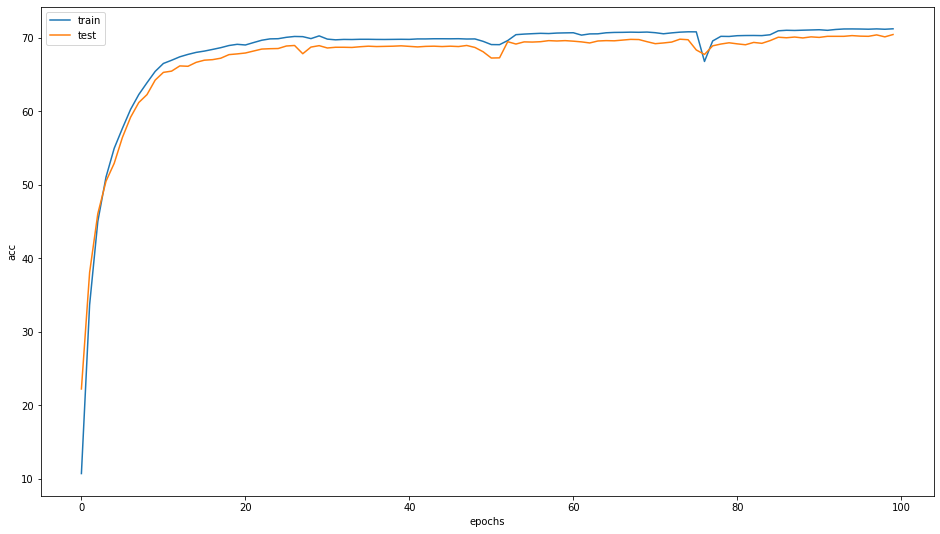

In [64]:
plt.figure(figsize=(16,9))
x_range=range(len(trn_acc_list))
plt.plot(x_range,trn_acc_list,label="train")
plt.plot(x_range,tst_acc_list,label="test")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("acc")